# **Material Search**

> This notebook is to be used for the Data Science MSc Thesis of Gustavo Fonseca. Data is provided by Mota Engil and should support the Supply Chain in the Mota-Engil group.

---

## **Introduction**

**Objective**: cluster the materials by similarity to each other. Ideally we are going to be able to categorize according to the similarity of the materials.

I start by:
1. Exploring the dataset and showing why I end up not using a lot of information;
2. Test levenshtein distance betweeen words and custom distance metric for sentences that uses word levenshtein distance;
3. Optimize the code in order to be able to process all the materials;
4. Apply a Nearest Neighbors algorithm to obtain clusters.

## **Imports**

In [1]:
# Imports to get data from Azure
import json
import textwrap
import unicodedata as unic
from collections import Counter
import re
import string
import urllib

# Standard imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import editdistance as ed
import pyodbc
import sqlalchemy

# Text Processing
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Clustering models
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# MP for distance calculation
from multiprocessing import cpu_count, Pool, sharedctypes

import locale
print(locale.getpreferredencoding())
%matplotlib inline

UTF-8


In [2]:
# Downloads needed for NLTK
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /home/dabin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dabin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/dabin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Connect and Extract the data from Azure SQL Database**

Connect to SQL Database to Extract the data. I use an SQL Query to get more information from the materials.

In [3]:
GET_DATA = False

if GET_DATA:
    
    # We load the secrets from a json file
    with open('variables/variables.json') as f:
          vars_ = json.load(f)


    # Specify the Driver.
    driver = '{ODBC Driver 17 for SQL Server}'

    # Specify Server Name and Database Name.
    server_name = vars_['server_name']
    database = vars_['database']

    # Create our Server URL.
    server = f'{server_name}.database.windows.net,1433'

    # Define Username & Password # TODO
    login = vars_['login']
    password = vars_['password']

    # Create the full connection string.
    connection_string = textwrap.dedent(f'''
        Driver={driver};
        Server={server};
        Database={database};
        Uid={login};
        Pwd={password};
        Encrypt=yes;
        TrustServerCertificate=no;
        Connection Timeout=30;
    ''')

    # Create a new PYODBC Connection Object
    cnxn: pyodbc.Connection = pyodbc.connect(connection_string)

    # Create a new Cursor Object from the connection
    crsr: pyodbc.Cursor = cnxn.cursor()

    # Define a select Query.
    select_sql = """
    SELECT
        zmm001.material_id, 
        CAST(zmm001.material_description AS VARCHAR(MAX)) AS material_description, 
        zmm001.material_group, 
        CAST(zmm001.material_group_description AS VARCHAR(MAX)) AS material_group_description, 
        zmm001.unit, 
        zmm001.material_type, 
        zmm001.created_date, 
        zmm001.last_change_date, 
        ISNULL(AVG(mb51_view.value_per_unit), '0') as average_price,
        ISNULL(STDEV(mb51_view.value_per_unit), '0') as std_price,
        ISNULL(COUNT(mb51_view.value_per_unit), '0') as count_movements
    FROM proc_db.zmm001 AS zmm001
    
    LEFT JOIN (
        SELECT material_id, movement_value_euro / quantity AS value_per_unit
        FROM proc_db.mb51_view AS mb51_view
        WHERE quantity > 0
    ) AS mb51_view
    ON mb51_view.material_id=zmm001.material_id
    
    GROUP BY
        zmm001.material_id,
        CAST(zmm001.material_description AS VARCHAR(MAX)),
        zmm001.material_group,
        CAST(zmm001.material_group_description AS VARCHAR(MAX)),
        zmm001.unit,
        zmm001.material_type,
        zmm001.created_date,
        zmm001.last_change_date
    """

    # Read to Pandas
    data = pd.read_sql(select_sql, cnxn)

    # Close the connection once we are done
    cnxn.close()
    
    data['created_date'] = pd.to_datetime(data['created_date'])
    data['last_change_date'] = pd.to_datetime(data['last_change_date'])
    data = data.replace(['', 'null', '#N/A'], [np.nan, np.nan, np.nan])
    
    data.to_csv('data/material_data.csv', index=False)

else:
    # In case we already have read the data from SQL, we already have saved it
    # and we can load it directly from the folder.
    data = pd.read_csv(
        'data/material_data.csv', 
        dtype={
            'material_id': str, 
            'material_description': str, 
            'material_group': str, 
            'material_group_description': str, 
            'unit': str, 
            'material_type': str, 
            'created_date': str, 
            'last_change_date': str,
            'average_price': float,
            'std_price': float,
            'count_movements': int
        },
        parse_dates=['created_date', 'last_change_date'])

## **Data Exploration**

This section is focused in analysing the data and seeing their worth for the purpose of this project. We want data that would allow to calculate similarities between the materials

In [ ]:
data.head()

We start by fixing some found description problems:
* 2+ white spaces are turned into only 1 space
* NaNs are turned into None

In [5]:
# Change 2 spacings to 1 spacing
data = data.replace('\s{2,}', ' ', regex=True)

# NaN to None
data = data.replace({np.nan: None})

The following code gathers some general statistics for each of the columns so we can see if any of them is useful for identifying materials.

In [6]:
# Get the cardinality and number of null values for each column

# Material is primary key therefore it is never null

cols_to_check = [
    'material_description',
    'material_group',
    'material_group_description',
    'unit',
    'material_type',
    'created_date',
    'last_change_date',
]

cols_numbers = [
    'average_price',
    'std_price',
    'count_movements'
]

stats_data = np.empty([len(cols_to_check) +  len(cols_numbers), 6], dtype=int)
types = []
nr_words = []

for i, col in enumerate(cols_to_check):
    stats_data[i, :] = [len(data[col].unique()), (data[col].isnull()).sum(), (data[col]=='').sum(), 0, 0, 0]
    types.append(data[col].dtype)
    
for i, col in enumerate(cols_numbers):
    stats_data[i + 7, :] = [len(data[col].unique()), (data[col].isnull()).sum(), (data[col]=='').sum(), (data[col]==0).sum(), int(data[col].min()), int(data[col].max())]
    types.append(data[col].dtype)
    
stats_data = pd.DataFrame(stats_data, columns=['Cardinality', 'Nulls', 'Blank', 'Zeros', 'Min', 'Max'], index=cols_to_check+cols_numbers)
stats_data['Dtype'] = types


for col in ['created_date', 'last_change_date']:
    stats_data.loc[col, 'Min'] = data[col].dt.date.min()
    stats_data.loc[col, 'Max'] = data[col].dt.date.max()

stats_data.head(10)

,Cardinality,Nulls,Blank,Zeros,Min,Max,Dtype
material_description,144558,1170,0,0,0,0,object
material_group,818,0,0,0,0,0,object
material_group_description,675,98,0,0,0,0,object
unit,40,0,0,0,0,0,object
material_type,7,0,0,0,0,0,object
created_date,504,0,0,0,2018-12-17,2021-08-30,datetime64[ns]
last_change_date,399,0,0,0,2019-04-12,2021-12-08,datetime64[ns]
average_price,115907,0,0,117715,0,1439956,float64
std_price,53086,0,0,184684,0,1102821,float64
count_movements,266,0,0,88926,0,4626,int64


**average_price** and **std_price** have both a lot of zeros, which are indicative of no price information. These 0s represent more than 50% of the data. So I will proceed with eliminating these columns.

In [7]:
data = data.drop(columns=['average_price', 'std_price']) # delete columns

The **created_date** and **last_change_date** can be indicative of similar seasonal needs but with so many diverse projects happening at the same time, it is also risky trying to infer anything with it.

In [8]:
data = data.drop(columns=['created_date', 'last_change_date'])

A very big percentage of materials have no registered movement, therefore it should also be hard to cluster using this information. In any case this data can be used to sort the results from the material search in the end.

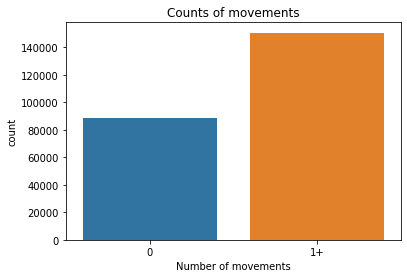

In [9]:
data['movements_category'] = data['count_movements'].apply(lambda x: '0' if x < 1 else '1+')
ax = sns.countplot(data=data, x='movements_category')
ax.set_xlabel('Number of movements')
ax.set_title('Counts of movements');

In [10]:
data = data.drop(columns=['count_movements', 'movements_category'])

We can also delete the units. Sometimes they vary because users prefer to deal for example with: liters instead of other units, and that should not differentiate the different materials.

In [11]:
data = data.drop(columns=['unit'])

In [ ]:
# End result
data.head()

> **Outcome**
We will calculate distances between the material descriptions.

After several meetings, we know now that searches are done using two types of information: 1) Tools & Equipment part number, and 2) Material description. In this case we will filter only materials (ZMAT) from the dataset which are what users search for using the descriptions.

In [13]:
# Keep only ZMAT
print(f"All data is composed of {data.shape[0]} rows")
data = data[(data.material_type=='ZMAT')].copy()
print(f"Only ZMAT data is composed of {data.shape[0]} rows")

All data is composed of 239583 rows
Only ZMAT data is composed of 97037 rows


**material_group** is the **material_group_description** ID, and **material_type** we have only ZMAT, so we will eliminate both of these columns since they are no longer needed.

In [14]:
data.drop(columns=['material_group', 'material_type'], inplace=True)

**material_group_description** and can be considered an already defined cluster of materials, so we can use them to calculate evaluation metrics with pseudo ground truth. They won't be reliable since there exist mixed types of groups: some are grouped by the brand (e.g. Volvo and Toyota) and others are grouped by their utility.

In [15]:
# We will save the MaterialGroupDescription for evaluating the results after
ground_truth = data['material_group_description']
data = data.drop(columns=['material_group_description'])

# **Calculating Distances**

For calculating distances between the materials, we will use the Levenshtein Distance for the words themselves, and increased distance for every unmatched word between the materials.

### Data Cleaning

First we create a new column with the cleaned up description.

In [ ]:
# first we turn the description into a cleaned version

# function to extract type of word
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


# multiple functions to clean the t
def clean_text(text):
    # clean any unicode formatting left
    text = unic.normalize("NFKD", text)
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # replace the rest of the punctuation by space
    text = ' '.join(text)
    text = [w for w in re.split('\.|\-|\s|\,|\(|\_|\d', text)]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words | Not really needed
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty
    text = [t for t in text if len(t) > 1]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0],  get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
data["clean_description"] = data["material_description"].apply(lambda x: clean_text(x) if x is not None else "")
data.head()

Now that we have the cleaned up descriptions, we can see what are the most common words in them.

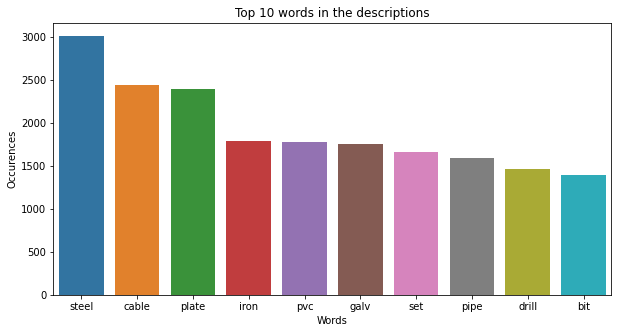

In [17]:
# Top 10 words after cleaning
top10words_df = pd.DataFrame(Counter(" ".join(data["clean_description"]).split()).most_common(10), columns=['Words', 'Occurences'])
plt.figure(figsize=(10,5))
ax = sns.barplot(data=top10words_df, x='Words', y='Occurences')
ax.set_title('Top 10 words in the descriptions')
plt.savefig('images/top10words.png');

Since the cleanup returned empty strings for some materials, we will consider them undefined materials

In [18]:
# missing description will be set to undefined
data.loc[data.clean_description.str.contains('^\s*$'), 'clean_description'] = 'undefined'

Now that we have clean descriptions, we can now focus on calculating distances between the different texts with the levenshtein distance both for words and then for sentences.

### **Levenshtein distance for words**

To start, with the levenshtein distance, we have a custom function:

In [19]:
def levenshtein_dist_word(token1, token2):
    """Levenshtein distance for words."""
    
    # We start by getting the lengths of each word
    m = len(token1)
    n = len(token2)
    
    # The distance matrix is initialized
    distances = np.zeros((m + 1, n + 1))
    # Setting of 1 to N+1 and M+1 in side of matrix
    for t1 in range(m + 1):
        distances[t1][0] = t1
    for t2 in range(n + 1):
        distances[0][t2] = t2
            
    # We build the matrix similarity
    for t1 in range(1, m + 1):
        for t2 in range(1, n + 1):
            # If the letter is the same the value will be the same as the upper left value
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                # Insertion value is above
                insertion = distances[t1][t2 - 1]
                # Deletion value is to the left
                deletion = distances[t1 - 1][t2]
                # Substitution is upper left
                substitution = distances[t1 - 1][t2 - 1]
                
                # If insertion is a minimum value, we use that value and give it a penalty of 1
                if (insertion <= deletion and insertion <= substitution):
                    distances[t1][t2] = insertion + 1
                # If deletion is a minimum value, we use that value and give it a penalty of 1
                elif (deletion <= insertion and deletion <= substitution):
                    distances[t1][t2] = deletion + 1
                # If substitution is a minimum value, we use that value and give it a penalty of 1
                else:
                    distances[t1][t2] = substitution + 1

    # We take the lower right value of the matrix
    final_dist = distances[-1][-1]
    # Calculate how much of the word has changed
    lword = max(m,n)
    ratio = (lword - final_dist) / lword 
    
    # Some words are incomplete so we check the matrix to see if there is any word
    # that is the incomplete version of the other.
    
    if (np.any(distances[:,-1]==0)) or (np.any(distances[-1,:]==0)):
        ratio = 0.9
        
    # print_distances(distances, m, n)
    
    return final_dist

In [20]:
%%time

levenshtein_dist_word('amazingfantasticoulosimundo', 'amazcoulosimundo')

CPU times: user 479 µs, sys: 36 µs, total: 515 µs
Wall time: 478 µs


11.0

There are also some other alternatives, such as the `editdistance.eval` levenshtein distance, tested below:

In [21]:
%%time

ed.eval('amazingfantasticoulosimundo', 'amazcoulosimundo')

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 13.4 µs


11

`editdistance` package is implemented in Cython and C++ which makes it way faster than the manually implemented one. So we will continue with the editdistance levenshtein distance calculation. Even though it is not adjusted to give more value to incomplete words of others (i.e. galv and galvanized).


The next function uses this function inside a sentence distance function to determine if a word is similar enough to another. In the sentence, the order of the words does not matter and this function reflects that.

In [22]:
def dist_sentence(sentence_1, sentence_2):
    """Distance for sentence adapted from levenshtein but with no fixed order."""
    initial = sentence_1 + "|" + sentence_2
    
    sentence_1_set = set(sentence_1.split(' '))
    sentence_2_set = set(sentence_2.split(' '))
    
    # Get the maximum length of the sentences to use in the end
    # when we have to calculate the percentage of difference between 
    # both sentences.
    ln_max = max(len(sentence_1_set), len(sentence_2_set))
    
    # Remove common words
    sentence_1_list = list(sentence_1_set - sentence_2_set)
    sentence_2_list = list(sentence_2_set - sentence_1_set)
    
    # Get the current lengths
    m = len(sentence_1_list)
    n = len(sentence_2_list)
    ln = max(m, n)

    # Initialize distance variable
    distance = 0
    
    # Find similar words
    for i, s1 in enumerate(sentence_1_list):
        # Continue if there are still values in sentence_2 list
        if sentence_2_list:
            values = np.zeros((1, n))
            for j, s2 in enumerate(sentence_2_list):
                l_word = max(len(s1),len(s2))
                values[0,j] = ed.eval(s1, s2) / l_word
            try:
                value = np.amin(values)
            except:
                print(initial)
            if value < 0.33:
                index = np.argmin(values)
                # Add relative leven distance to distance
                distance += value
                # Remove the tokens
                sentence_2_list.remove(sentence_2_list[index])
                ln -= 1
                n -= 1
    
    # Add the missing values that weren't matched
    distance += ln
    
    return int((distance / ln_max) * 100)

In [24]:
# Example

distance = dist_sentence("horse likes water", "morse likes milk")
print(f"Distance between 'horse likes water' and 'morse likes milk' is {distance}")

Distance between 'horse likes water' and 'morse likes milk' is 40


For calculating the distance between descriptions:
* gives a penalty of 1 for each different word, in this last example we have one different word.
* gives a partial penalty [0,1] when it has one similar word (morse -> horse) this is a normalized penalty according to the max word length. For this case we have one letter substitution from a five letter word therefore -> 0.2 of the word. Summed up we have 1 + 0.2 = 1.2. Then we divide the max number of words by this sum, so it is 1.2 / 3.0 = 0.4. To obtain an int8 distance matrix to save memory, we multiply the value by 100 and change to INT value. 

### **Testing Distance Matrix calculation**

### Single processing test

In [25]:
# Extract data
X = np.asarray(data['clean_description'].head(1000))

# Create the final output table to fill in
FINAL_OUTPUT = np.zeros((len(X),len(X)), dtype=np.int8)

In [26]:
def apply_leven(i, data):
    """Single processing function to apply sentence distance calculation."""
    
    # Only calculate distance matrix for the required values,
    # because the matrix is symetrical and the diagonal results are all 0
    j_start = i + 1
    s1 = data[i]
    for j, s2 in enumerate(data):
        if j < j_start:
            FINAL_OUTPUT[i,j] = 0
        else:
            FINAL_OUTPUT[i,j] = dist_sentence(s1, s2)

In [27]:
%%time

# Apply function with a for loop
for i in range(len(X)):
    apply_leven(i, X)

# Fill in the rest of the matrix
FINAL_OUTPUT += FINAL_OUTPUT.T

nbrs = NearestNeighbors(n_neighbors=1000, metric="precomputed").fit(FINAL_OUTPUT)
distances, indices = nbrs.kneighbors(FINAL_OUTPUT)
indices

CPU times: user 10.8 s, sys: 3.38 ms, total: 10.8 s
Wall time: 10.8 s


array([[  0, 959, 410, ..., 340, 327, 999],
       [  1, 164,  17, ..., 342, 329, 999],
       [686,   2, 687, ..., 342, 329, 999],
       ...,
       [997, 655, 659, ..., 342, 329, 999],
       [998, 655, 997, ..., 341, 328, 999],
       [999, 916, 961, ..., 340, 327, 998]])

### Multiprocessing test to improve speed

In [29]:
# Create the matrix and make it a shared array to be accessed by the different workers
FINAL_OUTPUT_RAW = np.zeros((len(X), len(X)), dtype=np.int8)
C_TYPE_OUTPUT = np.ctypeslib.as_ctypes(FINAL_OUTPUT_RAW)
SHARED_ARRAY = sharedctypes.RawArray(C_TYPE_OUTPUT._type_, C_TYPE_OUTPUT)

In [30]:
def apply_leven_mp(i, data):
    """Multiprocessing function to apply sentence distance calculation."""
    j_start = i + 1
    s1 = data[i]
    
    # Get the shared array
    TMP = np.ctypeslib.as_array(SHARED_ARRAY)

    for j, s2 in enumerate(data):
        if j < j_start:
            TMP[i, j] = 0
        else:
            TMP[i, j] = dist_sentence(s1, s2)

In [31]:
%%time

pool = Pool(processes=cpu_count())
args = [(i, X) for i in range(len(X))]
res = pool.starmap(apply_leven_mp, args)
FINAL_OUTPUT_MP = np.ctypeslib.as_array(SHARED_ARRAY)

# Fill in the rest of the matrix
FINAL_OUTPUT_MP += FINAL_OUTPUT_MP.T

nbrs = NearestNeighbors(n_neighbors=1000, metric="precomputed").fit(FINAL_OUTPUT_MP)
distances, indices = nbrs.kneighbors(FINAL_OUTPUT_MP)
indices

CPU times: user 195 ms, sys: 123 ms, total: 318 ms
Wall time: 2.2 s


array([[  0, 959, 410, ..., 340, 327, 999],
       [  1, 164,  17, ..., 342, 329, 999],
       [686,   2, 687, ..., 342, 329, 999],
       ...,
       [997, 655, 659, ..., 342, 329, 999],
       [998, 655, 997, ..., 341, 328, 999],
       [999, 916, 961, ..., 340, 327, 998]])

In [32]:
if (FINAL_OUTPUT==FINAL_OUTPUT_MP).all():
    print("Matrices are the same!")

Matrices are the same!


### Using DBSCAN Processing

We will still apply DBSCAN in the next section, but before proceding we are going to show how the distance function could be applied to `sklearn.cluster.dbscan` metric parameter

In [33]:
%%time
# Function to get the strings using integers for their index in dataset
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0])     # extract indices
    return dist_sentence(X[i], X[j])


X_ints = np.arange(len(X)).reshape(-1, 1)

nbrs = NearestNeighbors(n_neighbors=1000, metric=lev_metric).fit(X_ints)
distances, indices = nbrs.kneighbors(X_ints)
indices

CPU times: user 11 s, sys: 4.14 ms, total: 11 s
Wall time: 11 s


array([[  0, 959, 410, ..., 340, 327, 999],
       [  1, 164,  17, ..., 342, 329, 999],
       [686,   2, 687, ..., 342, 329, 999],
       ...,
       [997, 655, 659, ..., 342, 329, 999],
       [998, 655, 997, ..., 341, 328, 999],
       [999, 916, 961, ..., 340, 327, 998]])

In [34]:
%%time
## We can also try using all the processors with the parameter n_jobs
nbrs = NearestNeighbors(n_neighbors=1000, metric=lev_metric,n_jobs=-1).fit(X_ints)
distances, indices = nbrs.kneighbors(X_ints)
indices

CPU times: user 27.6 s, sys: 325 ms, total: 28 s
Wall time: 27.1 s


array([[  0, 959, 410, ..., 340, 327, 999],
       [  1, 164,  17, ..., 342, 329, 999],
       [686,   2, 687, ..., 342, 329, 999],
       ...,
       [997, 655, 659, ..., 342, 329, 999],
       [998, 655, 997, ..., 341, 328, 999],
       [999, 916, 961, ..., 340, 327, 998]])

Interestingly, the DBSCAN processing with all processors seems to take more time, this might be because it is not taking proper advantage of using it with this function and should be getting a big penalty from the overhead.
To better understand these variations, the following section will obtain the performance gains with each of the variations.

### Measuring Performance

In [36]:
import time

sizes = [10,20,50,100,200,300, 400, 500, 600, 700, 800, 900, 1000,1500, 2000]
times_simple = []
times_mp = []
times_nbrs = []
times_nbrs_mp = []

for size in sizes:
    print(f"======================PROCESS SIZE {size} =======================")
    # Simple processing
    X = np.asarray(data['clean_description'].head(size))
    
    start = time.time()
    FINAL_OUTPUT = np.zeros((len(X),len(X)), dtype=np.int8)
    
    for i in range(len(X)):
        apply_leven(i, X)
    
    FINAL_OUTPUT += FINAL_OUTPUT.T
    nbrs = NearestNeighbors(n_neighbors=size, metric="precomputed").fit(FINAL_OUTPUT)
    _, _ = nbrs.kneighbors(FINAL_OUTPUT)
    end = time.time()
    times_simple.append(end-start)
    print(f"Time to process size {size} with one process was: {end-start:.6}s.")

    
    # Multiprocessing
    start = time.time()
    FINAL_OUTPUT_RAW = np.zeros((len(X), len(X)), dtype=np.int8)
    C_TYPE_OUTPUT = np.ctypeslib.as_ctypes(FINAL_OUTPUT_RAW)
    SHARED_ARRAY = sharedctypes.RawArray(C_TYPE_OUTPUT._type_, C_TYPE_OUTPUT)
    
    pool = Pool(processes=cpu_count())
    args = [(i, X) for i in range(len(X))]
    res = pool.starmap(apply_leven_mp, args)
    FINAL_OUTPUT_MP = np.ctypeslib.as_array(SHARED_ARRAY)
    
    FINAL_OUTPUT_MP += FINAL_OUTPUT_MP.T
    nbrs = NearestNeighbors(n_neighbors=size, metric="precomputed").fit(FINAL_OUTPUT_MP)
    _, _ = nbrs.kneighbors(FINAL_OUTPUT_MP)
    end = time.time()
    times_mp.append(end-start)
    print(f"Time to process size {size} with MP was: {end-start:.6}s.")
    
        
    if (FINAL_OUTPUT==FINAL_OUTPUT_MP).all():
        print("Matrices are the same!")
        
    
    # SKLean DBSCAN processing
    start = time.time()
    X_ints = np.arange(len(X)).reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=size, metric=lev_metric).fit(X_ints)
    _, _ = nbrs.kneighbors(X_ints)
    end = time.time()
    times_nbrs.append(end-start)
    print(f"Time to process size {size} with NearestNeighbors singleprocessing was: {end-start:.6}s.")
    
    
    # SKLean DBSCAN Multiprocessing
    start = time.time()
    X_ints = np.arange(len(X)).reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=size, metric=lev_metric, n_jobs=-1).fit(X_ints)
    _, _ = nbrs.kneighbors(X_ints)
    end = time.time()
    times_nbrs_mp.append(end-start)
    print(f"Time to process size {size} with NearestNeighbors MP was: {end-start:.6}s.")

======================PROCESS SIZE 10 =======================
Time to process size 10 with one process was: 0.00190902s.
Time to process size 10 with MP was: 0.126538s.
Matrices are the same!
Time to process size 10 with NearestNeighbors singleprocessing was: 0.00199699s.
Time to process size 10 with NearestNeighbors MP was: 0.00744843s.
======================PROCESS SIZE 20 =======================
Time to process size 20 with one process was: 0.00370955s.
Time to process size 20 with MP was: 0.12021s.
Matrices are the same!
Time to process size 20 with NearestNeighbors singleprocessing was: 0.00380874s.
Time to process size 20 with NearestNeighbors MP was: 0.0131502s.
======================PROCESS SIZE 50 =======================
Time to process size 50 with one process was: 0.0238829s.
Time to process size 50 with MP was: 0.116362s.
Matrices are the same!
Time to process size 50 with NearestNeighbors singleprocessing was: 0.0249059s.
Time to process size 50 with NearestNeighbors MP wa

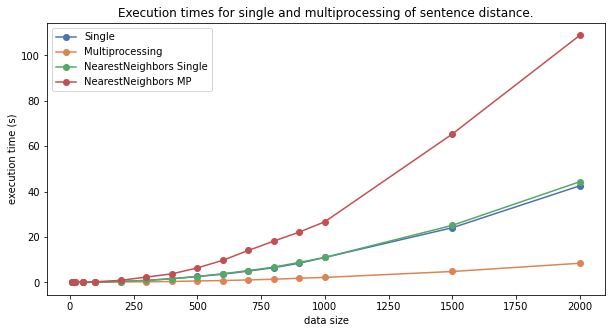

In [37]:
sns.set_palette("deep")
plt.figure(figsize=(10,5))
plt.title('Execution times for single and multiprocessing of sentence distance.')
plt.plot(sizes, times_simple, 'o-')
plt.plot(sizes, times_mp, 'o-')
plt.plot(sizes, times_nbrs, 'o-')
plt.plot(sizes, times_nbrs_mp, 'o-')
plt.legend(['Single', 'Multiprocessing', 'NearestNeighbors Single', 'NearestNeighbors MP'])
plt.xlabel('data size')
plt.ylabel('execution time (s)')
plt.savefig('images/performance_gain.png')
plt.show()

We can clearly decide that using the custom multiprocessing function is the one that will save us the biggest ammount of time. So we will proceed with this path.